In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lineartree import LinearBoostRegressor

from sklearn.linear_model import *
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
### READ DATA ###

df = pd.read_csv("daily-website-visitors.csv").drop('Row', axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['WeekOfYear'] = df['Date'].dt.week
df = df.replace(',', '', regex=True)

df.rename(columns={
    'Day.Of.Week':'DayOfWeek', 'Page.Loads':'PageLoads', 
    'Unique.Visits':'UniqueVisits', 'First.Time.Visits':'FirstVisits', 
    'Returning.Visits':'ReturningVisits'
}, inplace = True)

df['PageLoads'] = df['PageLoads'].astype(int)
df['UniqueVisits'] = df['UniqueVisits'].astype(int)
df['FirstVisits'] = df['FirstVisits'].astype(int)
df['ReturningVisits'] = df['ReturningVisits'].astype(int)

df.set_index('Date', inplace=True)

print(df.shape)
df.head()

(2167, 8)


,Day,DayOfWeek,PageLoads,UniqueVisits,FirstVisits,ReturningVisits,Month,WeekOfYear
Date,,,,,,,,
2014-09-14,Sunday,1,2146,1582,1430,152,9,37
2014-09-15,Monday,2,3621,2528,2297,231,9,38
2014-09-16,Tuesday,3,3698,2630,2352,278,9,38
2014-09-17,Wednesday,4,3667,2614,2327,287,9,38
2014-09-18,Thursday,5,3316,2366,2130,236,9,38


In [3]:
### CYCLIC ENCODING ###

def cyclic_encoding(df, col):
    
    max_val = df[col].max()
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    
    return df

df = cyclic_encoding(df, 'DayOfWeek')
df = cyclic_encoding(df, 'Month')
df = cyclic_encoding(df, 'WeekOfYear')

df.shape

(2167, 14)

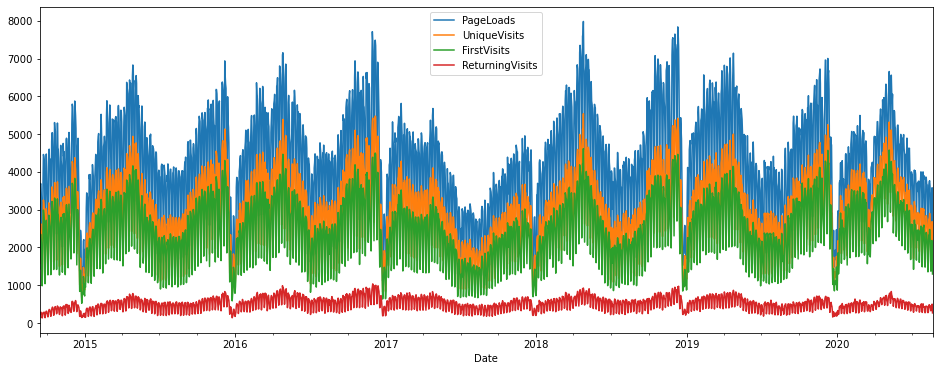

In [4]:
### PLOT TARGETS ###

targets = ['PageLoads' ,'UniqueVisits' ,'FirstVisits' ,'ReturningVisits']

df[targets].plot(figsize=(16,6))

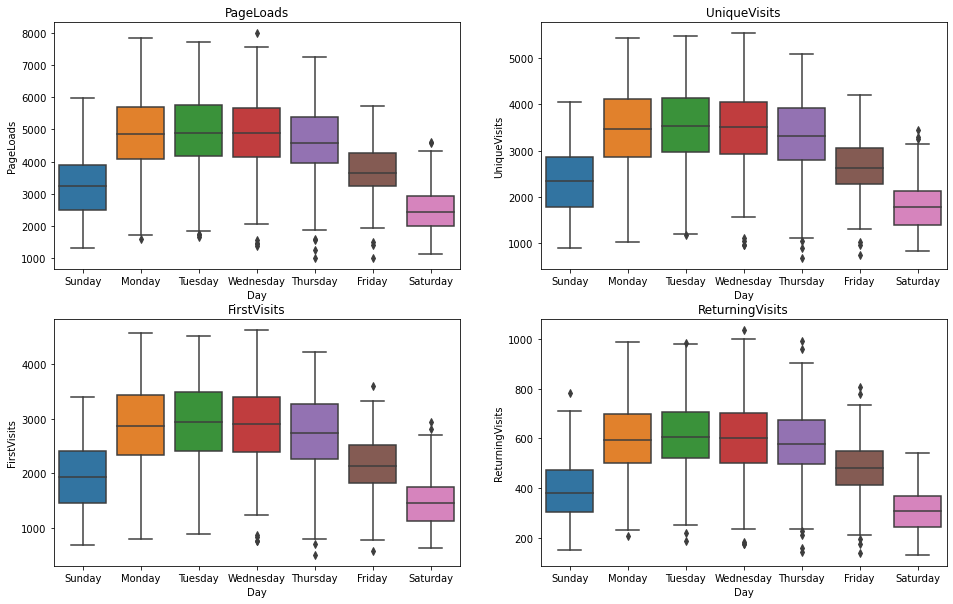

In [5]:
### PLOT DAILY PATTERNS ###

plt.figure(figsize=(16,10))

for i,t in enumerate(targets):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=df['Day'], y=df[t])
    plt.title(t)

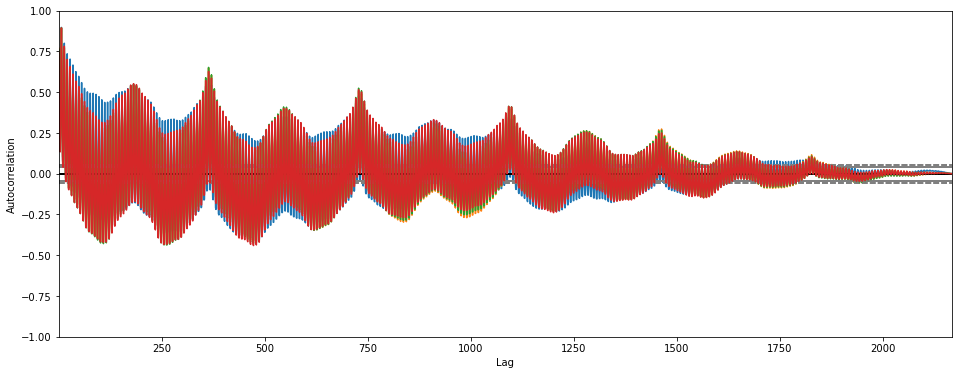

In [6]:
### PLOT AUTOCORRELATIONS ###

plt.figure(figsize=(16,6))

pd.plotting.autocorrelation_plot(df['ReturningVisits'])
pd.plotting.autocorrelation_plot(df['FirstVisits'])
pd.plotting.autocorrelation_plot(df['UniqueVisits'])
pd.plotting.autocorrelation_plot(df['PageLoads'])

In [7]:
### TRAIN-TEST SPLITS ###

X_train, X_test, y_train, y_test = train_test_split(
    df[['DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'WeekOfYear_sin', 'WeekOfYear_cos']], 
    df[targets], test_size=0.3, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1516, 6), (651, 6), (1516, 4), (651, 4))

In [8]:
### INITIALIZE EMPTY DICT TO STORE RESULTS ###

performances = {
    'LinearBoosting':{t:np.nan for t in targets}, 
    'LinearRegression':{t:np.nan for t in targets},
    'KnnFeatEng':{t:np.nan for t in targets}
}

# Forecast PageLoads

In [9]:
target = 'PageLoads'

In [10]:
### LINEAR BOOST FITTING ###

lin_boost = GridSearchCV(
    LinearBoostRegressor(Ridge()), 
    param_grid={
        'n_estimators': [5,10,20,30,40],
        'max_depth': [2,3,4,5]
    }, cv=3, n_jobs=None
)

lin_boost.fit(X_train, y_train[target])
pred_lin_boost = pd.Series(lin_boost.predict(X_test), index=y_test.index, name='LinearBoosting')
score = round(mean_squared_error(y_test[target], pred_lin_boost, squared=False),4)
performances['LinearBoosting'][target] = score

print('BEST PARAMS: ', lin_boost.best_params_)
print('TEST RMSE: ', score)

BEST PARAMS:  {'max_depth': 3, 'n_estimators': 40}
TEST RMSE:  711.351


In [11]:
### LINEAR REG FITTING ###

lin_reg = GridSearchCV(
    Ridge(), param_grid={'alpha':[1,2,3,4,10]}, cv=3, n_jobs=-1
)

lin_reg.fit(X_train, y_train[target])
pred_lin_reg = pd.Series(lin_reg.predict(X_test), index=y_test.index, name='LinearRegression')
score = round(mean_squared_error(y_test[target], pred_lin_reg, squared=False),4)
performances['LinearRegression'][target] = score

print('BEST PARAMS: ', lin_reg.best_params_)
print('TEST RMSE: ', score)

BEST PARAMS:  {'alpha': 1}
TEST RMSE:  1054.345


In [12]:
### KNN+FEATENGINE FITTING ###

pipe = make_pipeline(LinearBoostRegressor(Ridge()), KNeighborsRegressor())
pipe_boost = GridSearchCV(
    pipe, 
    param_grid={
        'linearboostregressor__n_estimators': [5,10,20,30,40],
        'linearboostregressor__max_depth': [2,3,4,5],
        'kneighborsregressor__n_neighbors': [3,5,7]
    }, cv=3, n_jobs=-1
)
pipe_boost.fit(X_train, y_train[target])
pred_pipe = pd.Series(pipe_boost.predict(X_test), index=y_test.index, name='KnnFeatEng')
score = round(mean_squared_error(y_test[target], pred_pipe, squared=False),4)
performances['KnnFeatEng'][target] = score

print('BEST PARAMS: ', pipe_boost.best_params_)
print('TEST RMSE: ', score)

BEST PARAMS:  {'kneighborsregressor__n_neighbors': 5, 'linearboostregressor__max_depth': 5, 'linearboostregressor__n_estimators': 5}
TEST RMSE:  678.2019


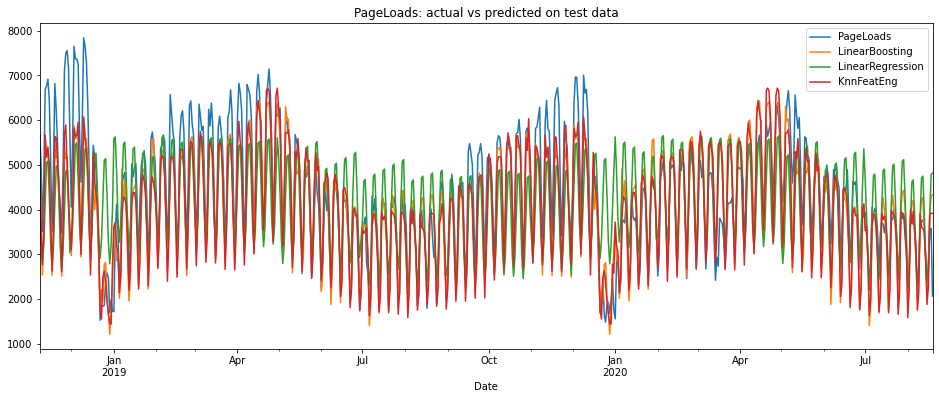

In [13]:
### PLOT PREDICTIONS ###

y_test[target].plot(figsize=(16,6))
pred_lin_boost.plot(figsize=(16,6))
pred_lin_reg.plot(figsize=(16,6))
pred_pipe.plot(figsize=(16,6))

plt.title("{}: actual vs predicted on test data".format(target))
plt.legend()

# Forecast UniqueVisits

In [14]:
target = 'UniqueVisits'

In [15]:
### LINEAR BOOST FITTING ###

lin_boost = GridSearchCV(
    LinearBoostRegressor(Ridge()), 
    param_grid={
        'n_estimators': [5,10,20,30,40],
        'max_depth': [2,3,4,5]
    }, cv=3, n_jobs=-1
)

lin_boost.fit(X_train, y_train[target])
pred_lin_boost = pd.Series(lin_boost.predict(X_test), index=y_test.index, name='LinearBoosting')
score = round(mean_squared_error(y_test[target], pred_lin_boost, squared=False),4)
performances['LinearBoosting'][target] = score

print('BEST PARAMS: ', lin_boost.best_params_)
print('TEST RMSE: ', score)

BEST PARAMS:  {'max_depth': 2, 'n_estimators': 40}
TEST RMSE:  488.7023


In [16]:
### LINEAR REG FITTING ###

lin_reg = GridSearchCV(
    Ridge(), param_grid={'alpha':[1,2,3,4,10]}, cv=3, n_jobs=-1
)

lin_reg.fit(X_train, y_train[target])
pred_lin_reg = pd.Series(lin_reg.predict(X_test), index=y_test.index, name='LinearRegression')
score = round(mean_squared_error(y_test[target], pred_lin_reg, squared=False),4)
performances['LinearRegression'][target] = score

print('BEST PARAMS: ', lin_reg.best_params_)
print('TEST RMSE: ', score)

BEST PARAMS:  {'alpha': 1}
TEST RMSE:  763.3364


In [17]:
### KNN+FEATENGINE FITTING ###

pipe = make_pipeline(LinearBoostRegressor(Ridge()), KNeighborsRegressor())
pipe_boost = GridSearchCV(
    pipe, 
    param_grid={
        'linearboostregressor__n_estimators': [5,10,20,30,40],
        'linearboostregressor__max_depth': [2,3,4,5],
        'kneighborsregressor__n_neighbors': [3,5,7]
    }, cv=3, n_jobs=-1
)
pipe_boost.fit(X_train, y_train[target])
pred_pipe = pd.Series(pipe_boost.predict(X_test), index=y_test.index, name='KnnFeatEng')
score = round(mean_squared_error(y_test[target], pred_pipe, squared=False),4)
performances['KnnFeatEng'][target] = score

print('BEST PARAMS: ', pipe_boost.best_params_)
print('TEST RMSE: ', score)

BEST PARAMS:  {'kneighborsregressor__n_neighbors': 5, 'linearboostregressor__max_depth': 5, 'linearboostregressor__n_estimators': 10}
TEST RMSE:  475.9974


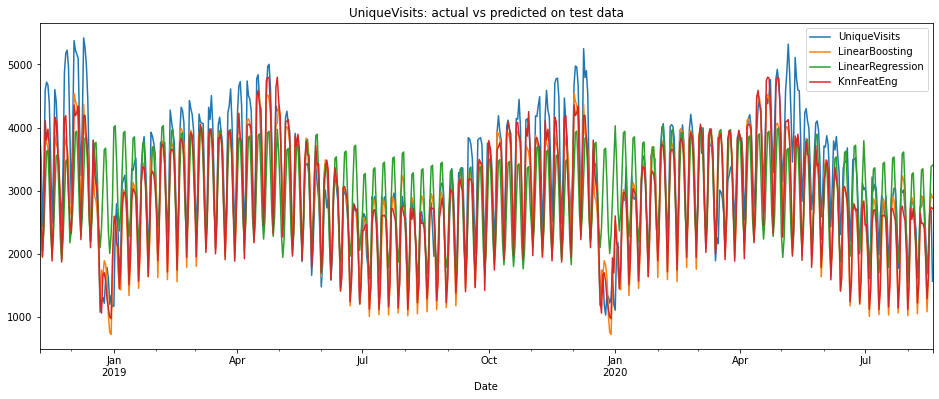

In [18]:
### PLOT PREDICTIONS ###

y_test[target].plot(figsize=(16,6))
pred_lin_boost.plot(figsize=(16,6))
pred_lin_reg.plot(figsize=(16,6))
pred_pipe.plot(figsize=(16,6))

plt.title("{}: actual vs predicted on test data".format(target))
plt.legend()

# Forecast FirstVisits

In [19]:
target = 'FirstVisits'

In [20]:
### LINEAR BOOST FITTING ###

lin_boost = GridSearchCV(
    LinearBoostRegressor(Ridge()), 
    param_grid={
        'n_estimators': [5,10,20,30,40],
        'max_depth': [2,3,4,5]
    }, cv=3, n_jobs=-1
)

lin_boost.fit(X_train, y_train[target])
pred_lin_boost = pd.Series(lin_boost.predict(X_test), index=y_test.index, name='LinearBoosting')
score = round(mean_squared_error(y_test[target], pred_lin_boost, squared=False),4)
performances['LinearBoosting'][target] = score

print('BEST PARAMS: ', lin_boost.best_params_)
print('TEST RMSE: ', score)

BEST PARAMS:  {'max_depth': 3, 'n_estimators': 40}
TEST RMSE:  455.5357


In [21]:
### LINEAR REG FITTING ###

lin_reg = GridSearchCV(
    Ridge(), param_grid={'alpha':[1,2,3,4,10]}, cv=3, n_jobs=-1
)

lin_reg.fit(X_train, y_train[target])
pred_lin_reg = pd.Series(lin_reg.predict(X_test), index=y_test.index, name='LinearRegression')
score = round(mean_squared_error(y_test[target], pred_lin_reg, squared=False),4)
performances['LinearRegression'][target] = score

print('BEST PARAMS: ', lin_reg.best_params_)
print('TEST RMSE: ', score)

BEST PARAMS:  {'alpha': 1}
TEST RMSE:  671.9928


In [22]:
### KNN+FEATENGINE FITTING ###

pipe = make_pipeline(LinearBoostRegressor(Ridge()), KNeighborsRegressor())
pipe_boost = GridSearchCV(
    pipe, 
    param_grid={
        'linearboostregressor__n_estimators': [5,10,20,30,40],
        'linearboostregressor__max_depth': [2,3,4,5],
        'kneighborsregressor__n_neighbors': [3,5,7]
    }, cv=3, n_jobs=-1
)
pipe_boost.fit(X_train, y_train[target])
pred_pipe = pd.Series(pipe_boost.predict(X_test), index=y_test.index, name='KnnFeatEng')
score = round(mean_squared_error(y_test[target], pred_pipe, squared=False),4)
performances['KnnFeatEng'][target] = score

print('BEST PARAMS: ', pipe_boost.best_params_)
print('TEST RMSE: ', score)

BEST PARAMS:  {'kneighborsregressor__n_neighbors': 3, 'linearboostregressor__max_depth': 3, 'linearboostregressor__n_estimators': 20}
TEST RMSE:  448.248


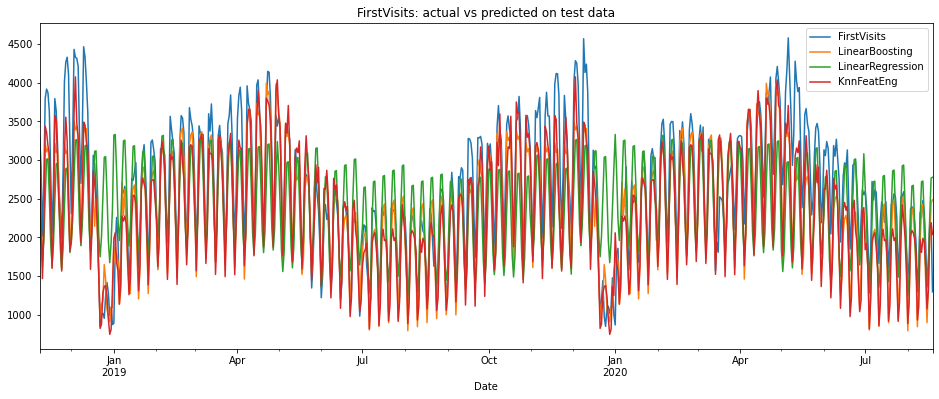

In [23]:
### PLOT PREDICTIONS ###

y_test[target].plot(figsize=(16,6))
pred_lin_boost.plot(figsize=(16,6))
pred_lin_reg.plot(figsize=(16,6))
pred_pipe.plot(figsize=(16,6))

plt.title("{}: actual vs predicted on test data".format(target))
plt.legend()

# Forecast ReturningVisits

In [24]:
target = 'ReturningVisits'

In [25]:
### LINEAR BOOST FITTING ###

lin_boost = GridSearchCV(
    LinearBoostRegressor(Ridge()), 
    param_grid={
        'n_estimators': [5,10,20,30,40],
        'max_depth': [2,3,4,5]
    }, cv=3, n_jobs=-1
)

lin_boost.fit(X_train, y_train[target])
pred_lin_boost = pd.Series(lin_boost.predict(X_test), index=y_test.index, name='LinearBoosting')
score = round(mean_squared_error(y_test[target], pred_lin_boost, squared=False),4)
performances['LinearBoosting'][target] = score

print('BEST PARAMS: ', lin_boost.best_params_)
print('TEST RMSE: ', score)

BEST PARAMS:  {'max_depth': 2, 'n_estimators': 40}
TEST RMSE:  85.72


In [26]:
### LINEAR REG FITTING ###

lin_reg = GridSearchCV(
    Ridge(), param_grid={'alpha':[1,2,3,4,10]}, cv=3, n_jobs=-1
)

lin_reg.fit(X_train, y_train[target])
pred_lin_reg = pd.Series(lin_reg.predict(X_test), index=y_test.index, name='LinearRegression')
score = round(mean_squared_error(y_test[target], pred_lin_reg, squared=False),4)
performances['LinearRegression'][target] = score

print('BEST PARAMS: ', lin_reg.best_params_)
print('TEST RMSE: ', score)

BEST PARAMS:  {'alpha': 1}
TEST RMSE:  124.1337


In [27]:
### KNN+FEATENGINE FITTING ###

pipe = make_pipeline(LinearBoostRegressor(Ridge()), KNeighborsRegressor())
pipe_boost = GridSearchCV(
    pipe, 
    param_grid={
        'linearboostregressor__n_estimators': [5,10,20,30,40],
        'linearboostregressor__max_depth': [2,3,4,5],
        'kneighborsregressor__n_neighbors': [3,5,7]
    }, cv=3, n_jobs=-1
)
pipe_boost.fit(X_train, y_train[target])
pred_pipe = pd.Series(pipe_boost.predict(X_test), index=y_test.index, name='KnnFeatEng')
score = round(mean_squared_error(y_test[target], pred_pipe, squared=False),4)
performances['KnnFeatEng'][target] = score

print('BEST PARAMS: ', pipe_boost.best_params_)
print('TEST RMSE: ', score)

BEST PARAMS:  {'kneighborsregressor__n_neighbors': 5, 'linearboostregressor__max_depth': 4, 'linearboostregressor__n_estimators': 10}
TEST RMSE:  84.3699


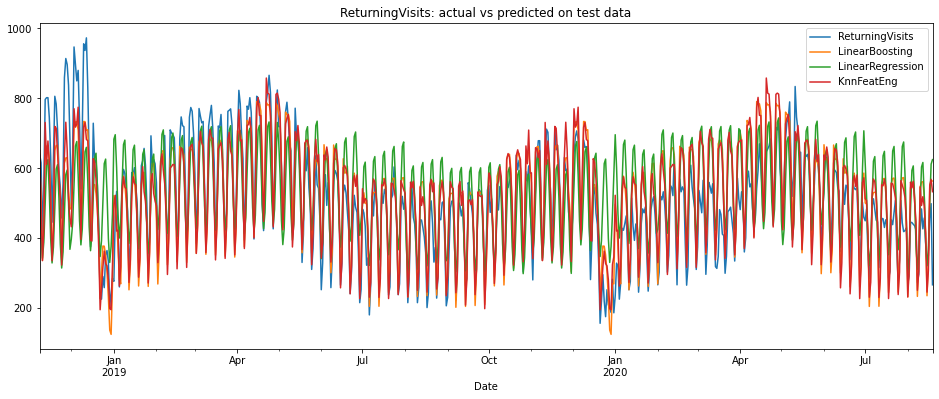

In [28]:
### PLOT PREDICTIONS ###

y_test[target].plot(figsize=(16,6))
pred_lin_boost.plot(figsize=(16,6))
pred_lin_reg.plot(figsize=(16,6))
pred_pipe.plot(figsize=(16,6))

plt.title("{}: actual vs predicted on test data".format(target))
plt.legend()

In [29]:
### COMPARE RESULTS ###

reductions = {}

for k in performances:
    reductions[k] = {}
    for t in targets:
        reductions[k][t] = performances[k][t]/performances['LinearRegression'][t]-1

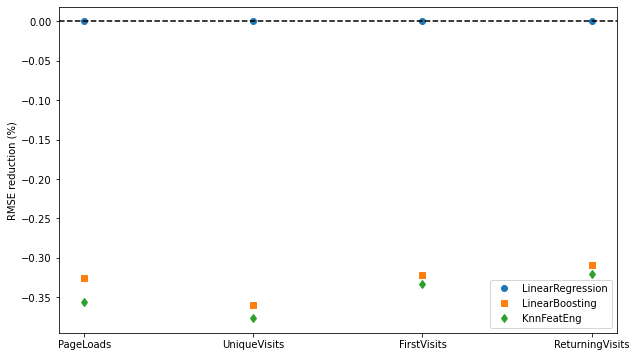

In [30]:
### PLOT COMPARED RESULTS ###

plt.figure(figsize=(10,6))
plt.plot(range(len(targets)), list(reductions['LinearRegression'].values()), 'o', label='LinearRegression')
plt.plot(range(len(targets)), list(reductions['LinearBoosting'].values()), 's', label='LinearBoosting')
plt.plot(range(len(targets)), list(reductions['KnnFeatEng'].values()), 'd', label='KnnFeatEng')
plt.axhline(0, linestyle='--', c='black')
plt.legend(); plt.ylabel('RMSE reduction (%)')
plt.xticks(range(len(targets)), list(reductions['LinearBoosting'].keys()))
plt.show()